# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/VGG16_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.0 -1.0 -1.0   
      201547 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.0 -1.0 -1.0   
      201548 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.0 -1.0 -1.0   
      201549 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.0 -1.0 -1.0   
      201550 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.0 -1.0 -1.0   

                9  ...       503       504       505       506       507  508  \
41001 201546 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638 -1.0   
      201547 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638 -1.0   
      201548 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638 -1.0   
      201549 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638 -1.0   
      201550 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638 -1.0   

              509       510  511    Labels  
41001 201546 -1.0 -0.322207 -1.0 -0.861740  
      201547 -1.0 -0.322207 -1.0 -0.854589  
      201548 -1.0 -0.322207 -1.0 -0.856973  
      201549 -1.0 -0.322207 -1.0 -0.856973  
      201550 -1.0 -0.322207 -1.0 -0.823600  

[5 rows x 513 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3         4    5         6    7  \
5360 201546 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.000000 -1.0   
     201547 -0.973348 -1.0 -0.980060 -0.884087 -0.642429 -1.0 -1.000000 -1.0   
     201548 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.000000 -1.0   
     201549 -0.942316 -1.0 -0.948253 -0.940424 -0.190784 -1.0 -0.979443 -1.0   
     201550 -0.993416 -1.0 -0.949038 -0.751881 -0.582074 -1.0 -1.000000 -1.0   

               8    9  ...       503       504       505       506       507  \
5360 201546 -1.0 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638   
     201547 -1.0 -1.0  ... -0.003052 -0.696596 -0.905498 -0.664986 -0.208431   
     201548 -1.0 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638   
     201549 -1.0 -1.0  ... -0.575710 -0.497805 -1.000000 -0.720364 -0.150779   
     201550 -1.0 -1.0  ... -0.158883 -0.661095 -0.878304 -0.570955 -0.372638   

             508       509       510  511    Labels  
5360 201546 -1.0 -1.000000 -0.322207 -1.0 -0.990465  
     201547 -1.0 -1.000000 -0.531258 -1.0 -0.969011  
     201548 -1.0 -1.000000 -0.322207 -1.0 -0.995232  
     201549 -1.0 -0.953651 -0.405075 -1.0 -0.997616  
     201550 -1.0 -1.000000 -0.322207 -1.0 -0.971395  

[5 rows x 513 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 513)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 512)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 512)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

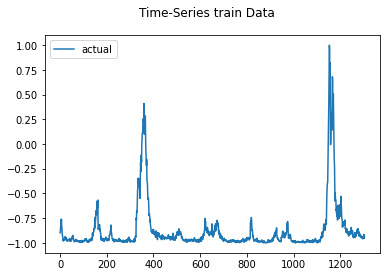

2023-03-04 23:52:01.740699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:52:01.740749: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:52:01.740778: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:52:01.741006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:52:01.842373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 80.771
Test sMAPE: 146.946
Test RMSE: 147.349
{'mae': 80.77106956598217, 'smape': 146.94637797394032, 'rmse': 147.3493845456729}


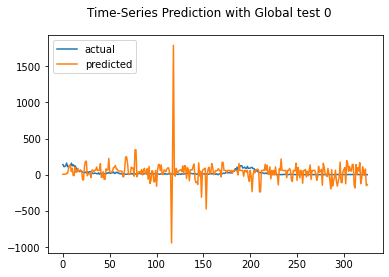

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 83.164
Test sMAPE: 140.761
Test RMSE: 156.535
{'mae': 83.1635870421591, 'smape': 140.76096929230206, 'rmse': 156.5350629487773}


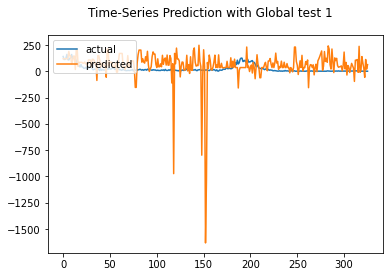

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 104.098
Test sMAPE: 157.453
Test RMSE: 168.691
{'mae': 104.0975127532804, 'smape': 157.45254408664175, 'rmse': 168.69052049888305}


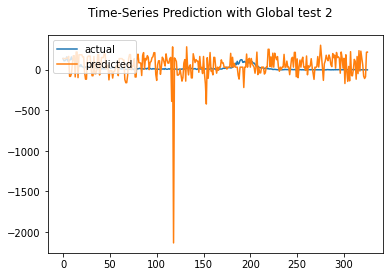

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 112.600
Test sMAPE: 172.833
Test RMSE: 386.861
{'mae': 112.60018580731439, 'smape': 172.83250811344928, 'rmse': 386.86064723534383}


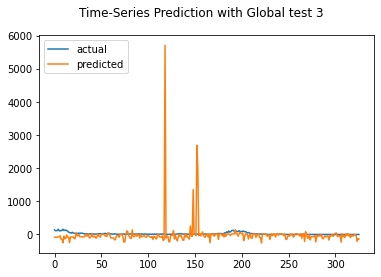

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 155.919
Test sMAPE: 168.086
Test RMSE: 240.716
{'mae': 155.9191059320251, 'smape': 168.08574900388686, 'rmse': 240.71627153186247}


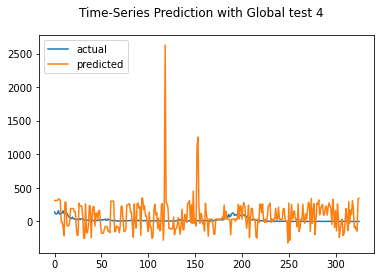

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 139.984
Test sMAPE: 171.065
Test RMSE: 215.431
{'mae': 139.98363569177732, 'smape': 171.06545516132795, 'rmse': 215.43143749663665}


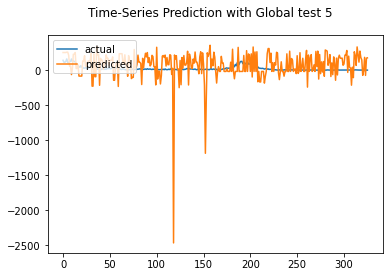

Test MAE: 95.396
Test sMAPE: 148.243
Test RMSE: 249.138
{'mae': 95.39555981106187, 'smape': 148.24255986604646, 'rmse': 249.1384597386784}


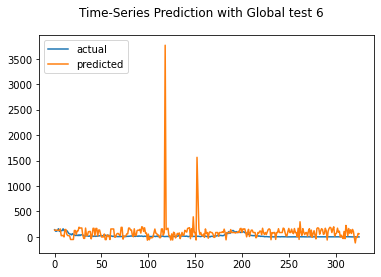

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 91.877
Test sMAPE: 160.930
Test RMSE: 126.244
{'mae': 91.87700756872358, 'smape': 160.93006562752467, 'rmse': 126.24352992862273}


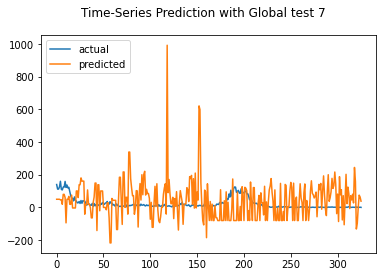

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 103.724
Test sMAPE: 177.735
Test RMSE: 206.957
{'mae': 103.72392136196783, 'smape': 177.73521220849037, 'rmse': 206.95672529227338}


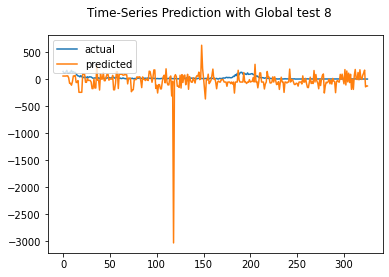

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 183.120
Test sMAPE: 183.389
Test RMSE: 252.955
{'mae': 183.11982943455865, 'smape': 183.3889378078577, 'rmse': 252.9553386972557}


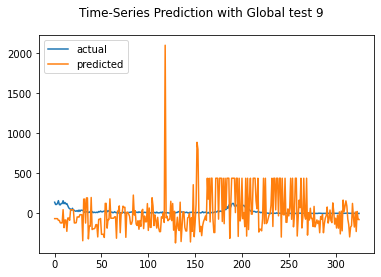

Test MAE: 62.708
Test sMAPE: 130.416
Test RMSE: 135.467
{'mae': 62.707726272337275, 'smape': 130.41592511153448, 'rmse': 135.4671036169513}


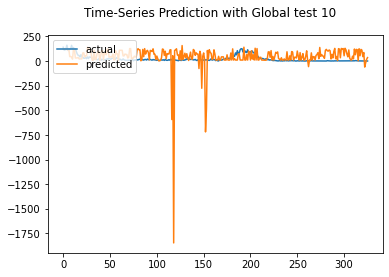

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 197.673
Test sMAPE: 165.753
Test RMSE: 222.017
{'mae': 197.6729925834328, 'smape': 165.75347593146017, 'rmse': 222.01686859398657}


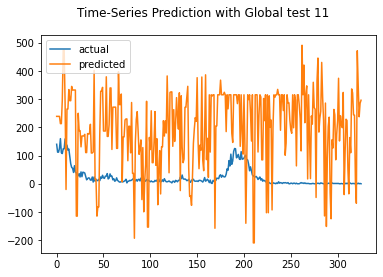

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 81.387
Test sMAPE: 145.909
Test RMSE: 115.657
{'mae': 81.3872504742599, 'smape': 145.90911473304402, 'rmse': 115.65746776735848}


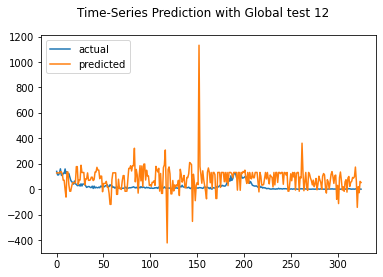

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 92.513
Test sMAPE: 148.335
Test RMSE: 151.025
{'mae': 92.51274305609472, 'smape': 148.3347620874889, 'rmse': 151.02461874836155}


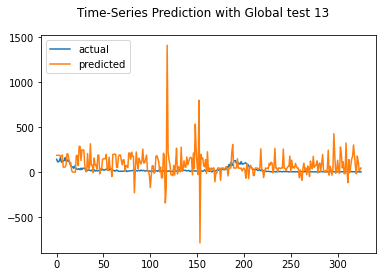

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 69.624
Test sMAPE: 146.268
Test RMSE: 102.734
{'mae': 69.62448648889006, 'smape': 146.26795559786194, 'rmse': 102.73441785838882}


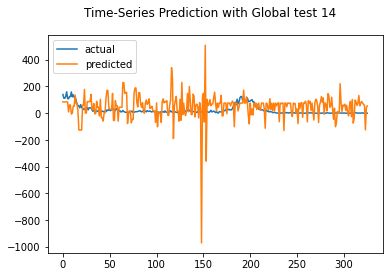

Test MAE: 51.580
Test sMAPE: 133.785
Test RMSE: 68.732
{'mae': 51.579983264573514, 'smape': 133.78532642266063, 'rmse': 68.73193985532}


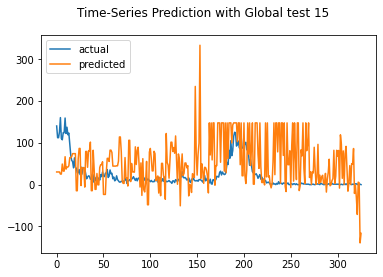

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 197.091
Test sMAPE: 166.924
Test RMSE: 222.470
{'mae': 197.09106547901968, 'smape': 166.92351515037544, 'rmse': 222.46968824749166}


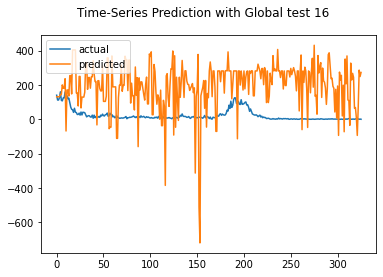

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 78.883
Test sMAPE: 169.021
Test RMSE: 101.509
{'mae': 78.88331290311609, 'smape': 169.02146478490923, 'rmse': 101.50913640293751}


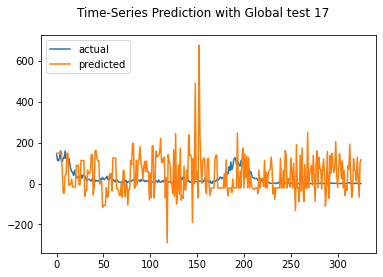

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 119.308
Test sMAPE: 154.783
Test RMSE: 370.644
{'mae': 119.30792363216541, 'smape': 154.7828454581429, 'rmse': 370.64448827829364}


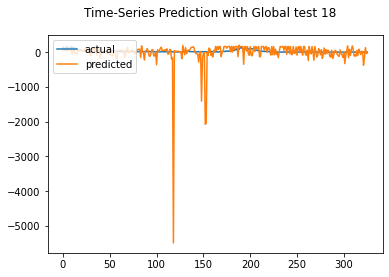

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 250.570
Test sMAPE: 171.346
Test RMSE: 272.105
{'mae': 250.56984959350774, 'smape': 171.34570286745955, 'rmse': 272.1052591499669}


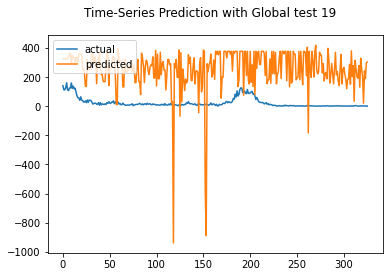

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 71.707
Test sMAPE: 149.463
Test RMSE: 98.900
{'mae': 71.70711096700715, 'smape': 149.46279496790183, 'rmse': 98.90044850834423}


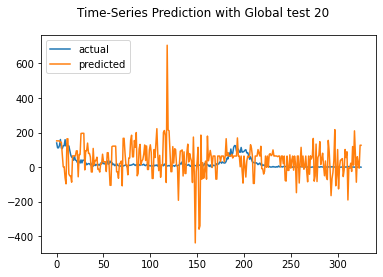

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 84.275
Test sMAPE: 150.724
Test RMSE: 142.438
{'mae': 84.27521483289318, 'smape': 150.7241173615449, 'rmse': 142.43766123153836}


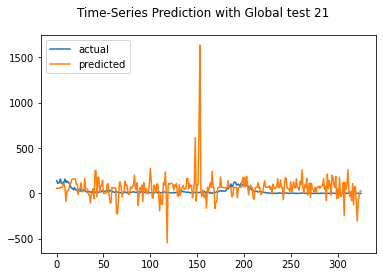

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 124.737
Test sMAPE: 173.594
Test RMSE: 227.124
{'mae': 124.7369605017586, 'smape': 173.5935255555962, 'rmse': 227.1241399596322}


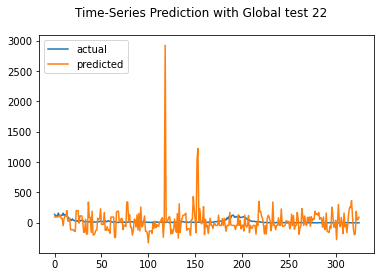

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 125.617
Test sMAPE: 177.136
Test RMSE: 176.224
{'mae': 125.61678954904065, 'smape': 177.13554754544495, 'rmse': 176.2236329068714}


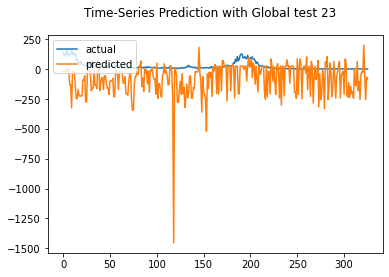

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 99.100
Test sMAPE: 165.668
Test RMSE: 321.537
{'mae': 99.10026654582813, 'smape': 165.6678819493738, 'rmse': 321.53694745983705}


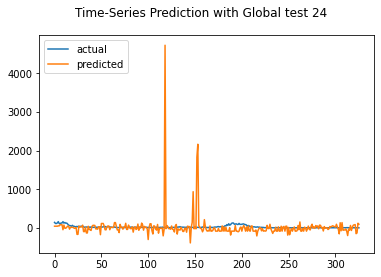

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 207.308
Test sMAPE: 175.569
Test RMSE: 244.433
{'mae': 207.30812399189895, 'smape': 175.56904855079802, 'rmse': 244.43261463446137}


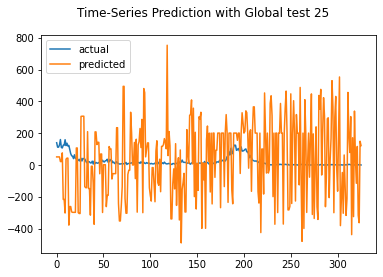

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 97.388
Test sMAPE: 166.902
Test RMSE: 154.918
{'mae': 97.38770278940903, 'smape': 166.90173685569263, 'rmse': 154.9176843323791}


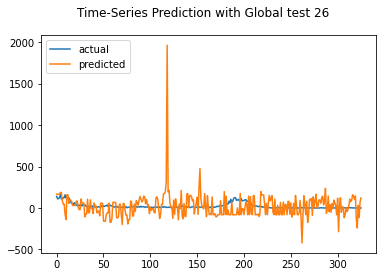

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 134.315
Test sMAPE: 175.012
Test RMSE: 172.960
{'mae': 134.31477911578367, 'smape': 175.01229309793308, 'rmse': 172.95962529546208}


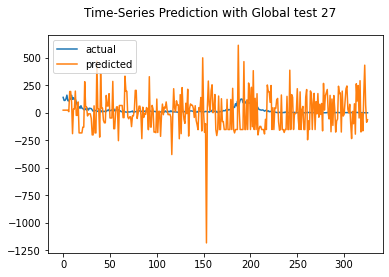

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 150.083
Test sMAPE: 165.586
Test RMSE: 209.748
{'mae': 150.0827091434982, 'smape': 165.58601669227596, 'rmse': 209.74799839510706}


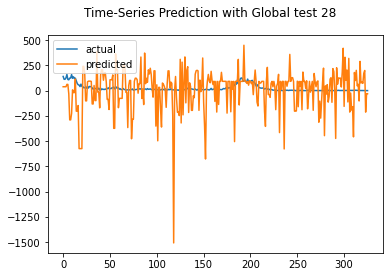

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 119.451
Test sMAPE: 167.499
Test RMSE: 231.011
{'mae': 119.45133838258639, 'smape': 167.49875950613963, 'rmse': 231.01071264064825}


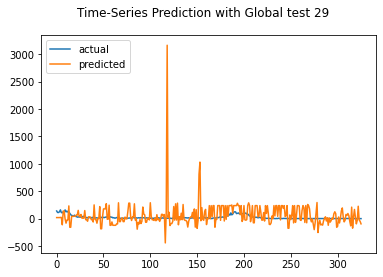

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 162.952
Test sMAPE: 165.599
Test RMSE: 358.834
{'mae': 162.95228579292998, 'smape': 165.59850474091988, 'rmse': 358.83398385949255}


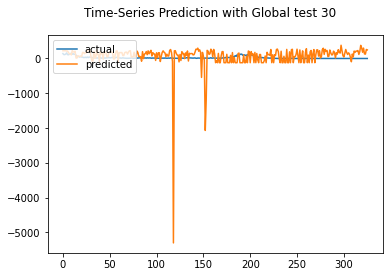

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 59.205
Test sMAPE: 140.571
Test RMSE: 102.715
{'mae': 59.204685179002446, 'smape': 140.57099018966207, 'rmse': 102.71488307508419}


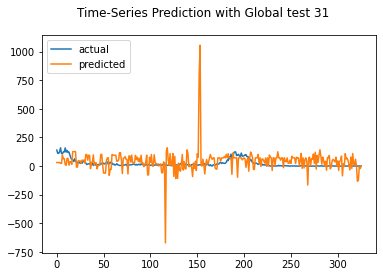

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 322.590
Test sMAPE: 183.598
Test RMSE: 421.375
{'mae': 322.58952233250153, 'smape': 183.59775515836904, 'rmse': 421.3745840875602}


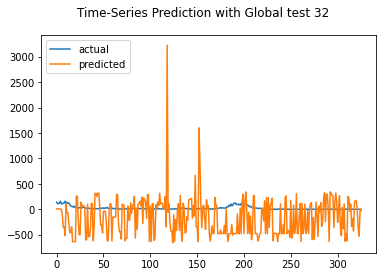

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 107.422
Test sMAPE: 149.051
Test RMSE: 153.662
{'mae': 107.42212264888857, 'smape': 149.05112625228395, 'rmse': 153.66235094875964}


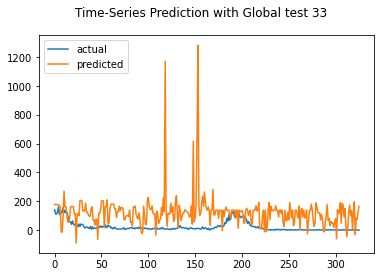

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 217.855
Test sMAPE: 175.036
Test RMSE: 290.371
{'mae': 217.85545311941326, 'smape': 175.03588541410198, 'rmse': 290.370879662359}


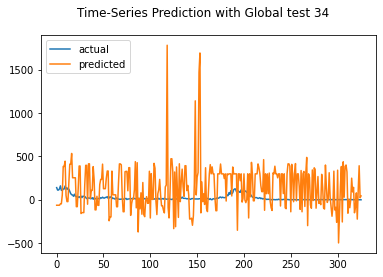

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 260.087
Test sMAPE: 196.272
Test RMSE: 323.553
{'mae': 260.08717367290717, 'smape': 196.27220605763623, 'rmse': 323.5525810446165}


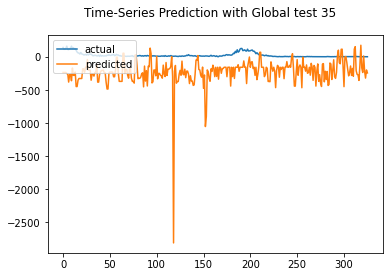

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 68.845
Test sMAPE: 162.925
Test RMSE: 127.540
{'mae': 68.84496911016345, 'smape': 162.9252782532889, 'rmse': 127.53971898472362}


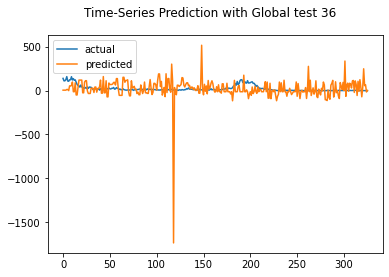

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 154.030
Test sMAPE: 166.628
Test RMSE: 176.657
{'mae': 154.0298730456756, 'smape': 166.62781212072193, 'rmse': 176.6570472591545}


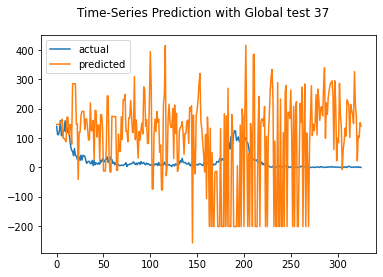

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 115.482
Test sMAPE: 171.130
Test RMSE: 223.165
{'mae': 115.4820635947713, 'smape': 171.12971338636467, 'rmse': 223.16517901747656}


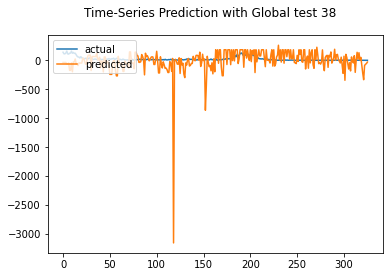

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 120.037
Test sMAPE: 159.125
Test RMSE: 147.979
{'mae': 120.03685885777503, 'smape': 159.12507016134825, 'rmse': 147.97862828874653}


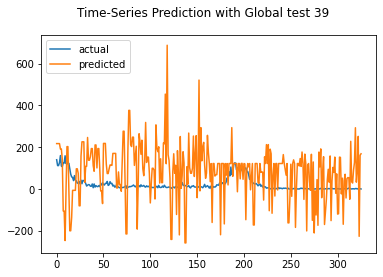

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 145.710
Test sMAPE: 156.044
Test RMSE: 181.315
{'mae': 145.71001327622886, 'smape': 156.04377887511296, 'rmse': 181.31477515037}


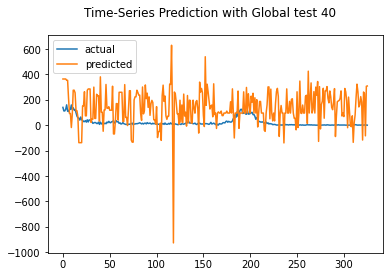

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 68.652
Test sMAPE: 162.717
Test RMSE: 99.028
{'mae': 68.65239692438234, 'smape': 162.7166410009642, 'rmse': 99.02809942984429}


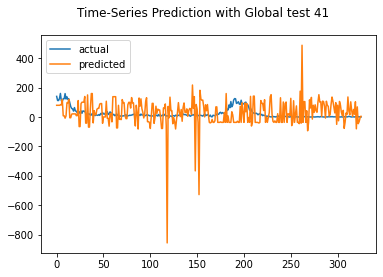

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 86.947
Test sMAPE: 146.761
Test RMSE: 167.157
{'mae': 86.94714512159489, 'smape': 146.76147180281336, 'rmse': 167.1566382758235}


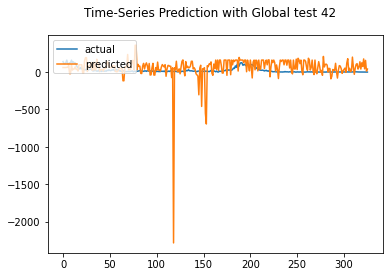

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 112.315
Test sMAPE: 167.810
Test RMSE: 188.086
{'mae': 112.31510851536791, 'smape': 167.81016480277222, 'rmse': 188.0858942217619}


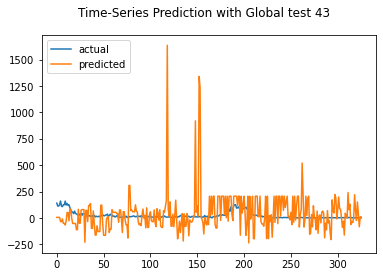

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 71.603
Test sMAPE: 148.417
Test RMSE: 162.058
{'mae': 71.60294785729947, 'smape': 148.41738683665469, 'rmse': 162.0576787659193}


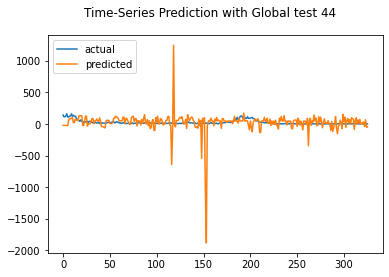

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 122.662
Test sMAPE: 152.583
Test RMSE: 147.946
{'mae': 122.66241851293601, 'smape': 152.5826101082477, 'rmse': 147.9457105292651}


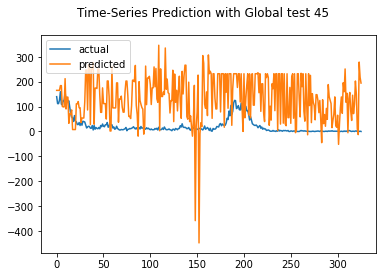

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 127.505
Test sMAPE: 153.269
Test RMSE: 174.742
{'mae': 127.50513273221584, 'smape': 153.2687645540717, 'rmse': 174.74171834044498}


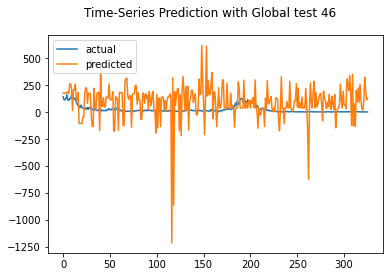

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 111.818
Test sMAPE: 156.040
Test RMSE: 146.047
{'mae': 111.81821901959144, 'smape': 156.0399419761606, 'rmse': 146.04701319171656}


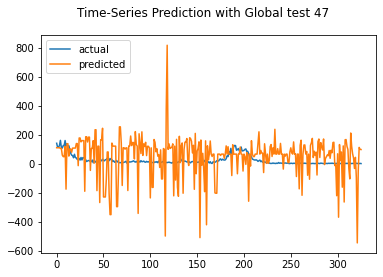

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 123.802
Test sMAPE: 154.853
Test RMSE: 150.370
{'mae': 123.80186948911545, 'smape': 154.8531433298694, 'rmse': 150.3699957079187}


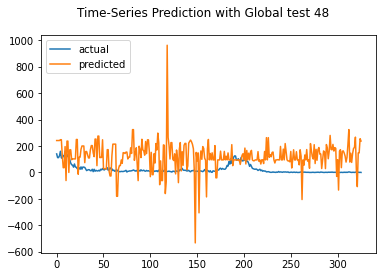

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 69.761
Test sMAPE: 137.945
Test RMSE: 125.348
{'mae': 69.76066690939335, 'smape': 137.94470267583233, 'rmse': 125.34843154453345}


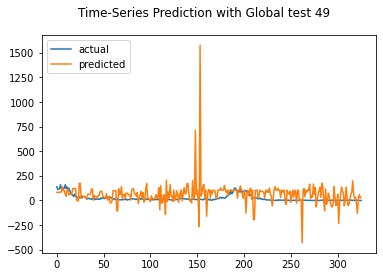

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 143.773
Test sMAPE: 172.279
Test RMSE: 198.081
{'mae': 143.77261232086485, 'smape': 172.27872643719058, 'rmse': 198.08143602206619}


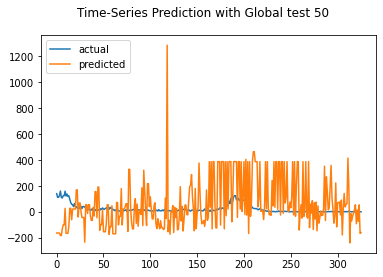

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 155.569
Test sMAPE: 174.838
Test RMSE: 245.484
{'mae': 155.56850591631024, 'smape': 174.8376991484865, 'rmse': 245.4839691000496}


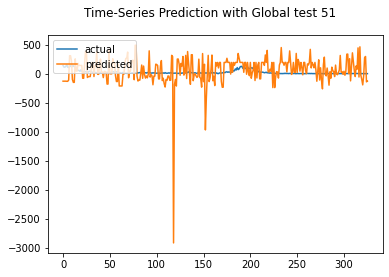

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 70.828
Test sMAPE: 139.606
Test RMSE: 114.835
{'mae': 70.82794880135658, 'smape': 139.60643344664535, 'rmse': 114.83455900196415}


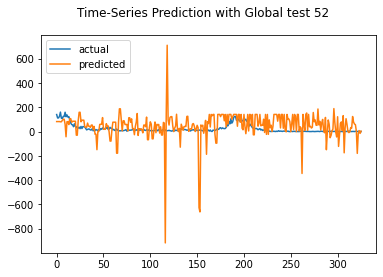

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 97.282
Test sMAPE: 164.354
Test RMSE: 257.946
{'mae': 97.28205803822885, 'smape': 164.35365147071266, 'rmse': 257.94571073909583}


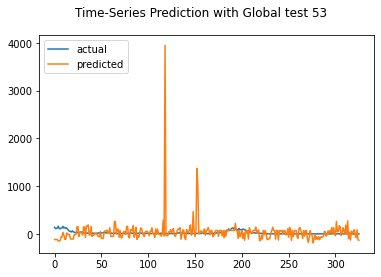

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 109.004
Test sMAPE: 149.187
Test RMSE: 210.853
{'mae': 109.00441245963238, 'smape': 149.18704810236744, 'rmse': 210.85275209105177}


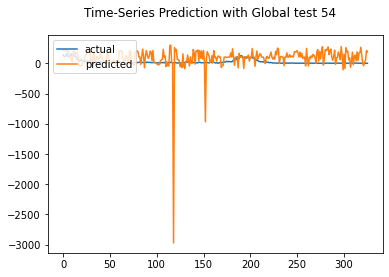

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 70.389
Test sMAPE: 143.285
Test RMSE: 106.452
{'mae': 70.38941868262057, 'smape': 143.28525847543915, 'rmse': 106.45156513972667}


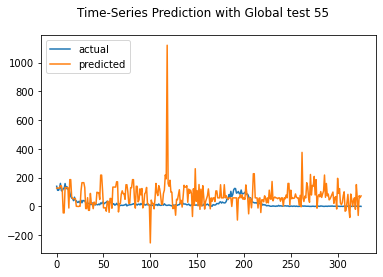

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 89.592
Test sMAPE: 160.117
Test RMSE: 115.514
{'mae': 89.59156833470233, 'smape': 160.11666643987198, 'rmse': 115.5138694865341}


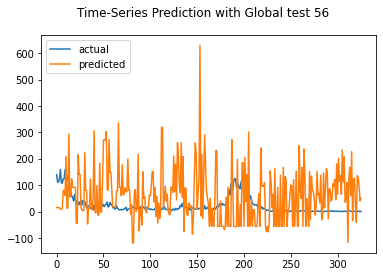

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 74.426
Test sMAPE: 154.476
Test RMSE: 147.187
{'mae': 74.42577916310609, 'smape': 154.4756715352049, 'rmse': 147.18719561343775}


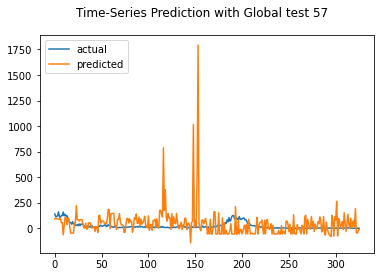

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 114.711
Test sMAPE: 180.371
Test RMSE: 173.454
{'mae': 114.711468752725, 'smape': 180.37088884713205, 'rmse': 173.45354063070502}


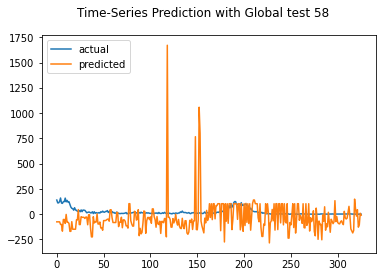

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 114.920
Test sMAPE: 157.002
Test RMSE: 137.565
{'mae': 114.92008424609716, 'smape': 157.00235009492087, 'rmse': 137.5647185870709}


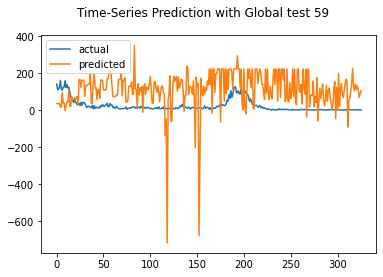

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 58.357
Test sMAPE: 155.236
Test RMSE: 111.804
{'mae': 58.357356651977526, 'smape': 155.23565320311408, 'rmse': 111.80420383674422}


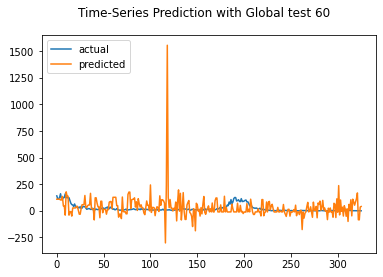

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 85.666
Test sMAPE: 151.011
Test RMSE: 123.521
{'mae': 85.66571777199675, 'smape': 151.0114150469498, 'rmse': 123.52096941507433}


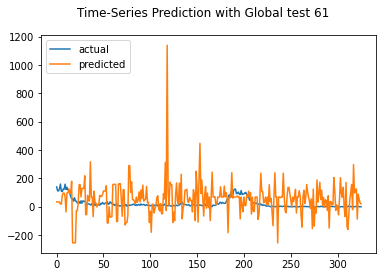

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 84.794
Test sMAPE: 161.743
Test RMSE: 107.089
{'mae': 84.7936637920836, 'smape': 161.7433971518272, 'rmse': 107.08898311311637}


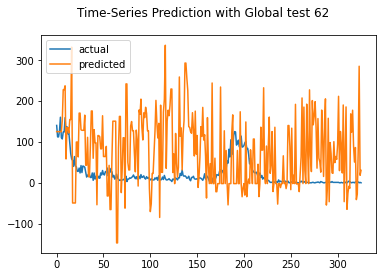

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 328.870
Test sMAPE: 184.138
Test RMSE: 409.963
{'mae': 328.8700846397072, 'smape': 184.13765871355486, 'rmse': 409.9634165575802}


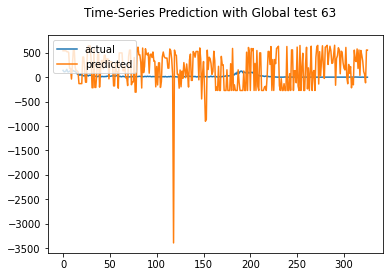

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 131.323
Test sMAPE: 172.054
Test RMSE: 160.510
{'mae': 131.32293207248662, 'smape': 172.0540636507715, 'rmse': 160.5100866808211}


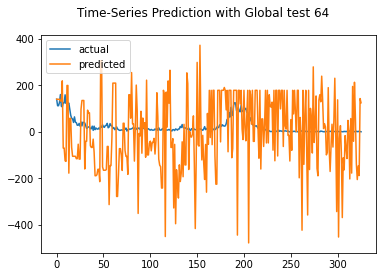

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 67.411
Test sMAPE: 137.940
Test RMSE: 112.359
{'mae': 67.41139206564499, 'smape': 137.93991952803913, 'rmse': 112.35905087164154}


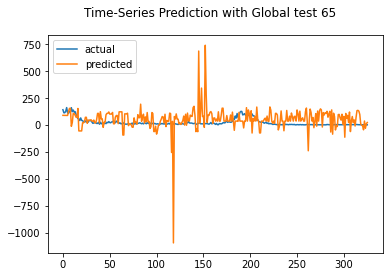

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 76.888
Test sMAPE: 152.028
Test RMSE: 111.841
{'mae': 76.88759476184114, 'smape': 152.0276342227083, 'rmse': 111.84116634391154}


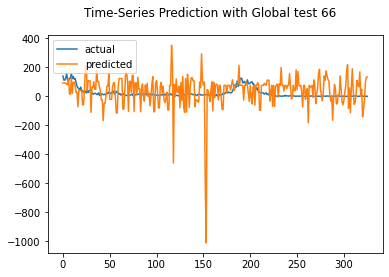

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 147.930
Test sMAPE: 161.639
Test RMSE: 215.476
{'mae': 147.92982836424207, 'smape': 161.63884774950338, 'rmse': 215.4761748830915}


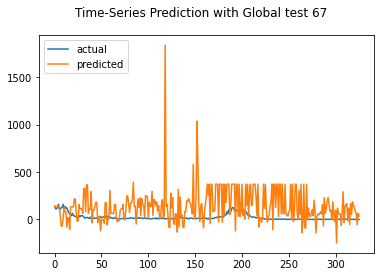

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 136.153
Test sMAPE: 172.979
Test RMSE: 374.265
{'mae': 136.1531279124548, 'smape': 172.97939255982124, 'rmse': 374.26461261451414}


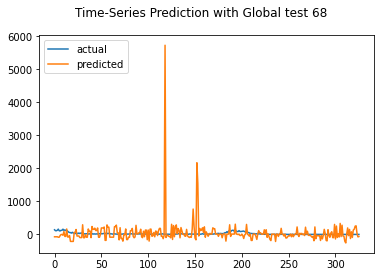

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 114.134
Test sMAPE: 153.125
Test RMSE: 168.722
{'mae': 114.13413688101652, 'smape': 153.12481545552558, 'rmse': 168.7216011249011}


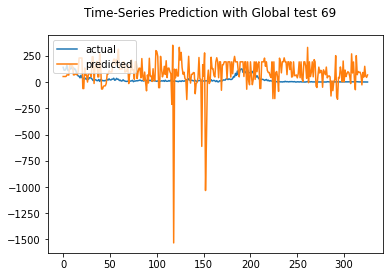

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 111.265
Test sMAPE: 152.041
Test RMSE: 197.810
{'mae': 111.2653298173214, 'smape': 152.0414888439041, 'rmse': 197.80991912319044}


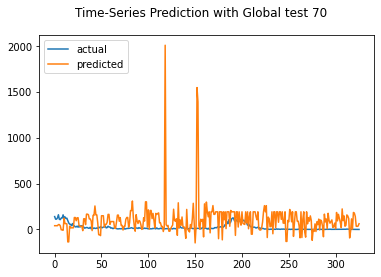

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 71.886
Test sMAPE: 148.949
Test RMSE: 194.159
{'mae': 71.88567813517857, 'smape': 148.94878375378377, 'rmse': 194.15910529647485}


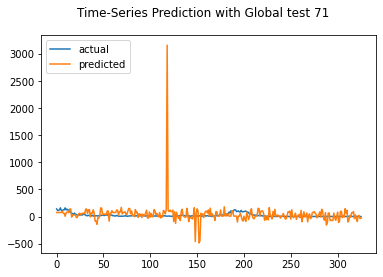

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 71.214
Test sMAPE: 148.672
Test RMSE: 98.161
{'mae': 71.2136196863432, 'smape': 148.67240471541933, 'rmse': 98.16140462844157}


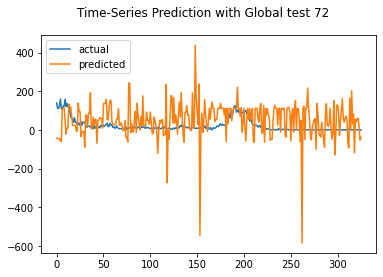

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 110.768
Test sMAPE: 156.904
Test RMSE: 173.250
{'mae': 110.76801676655109, 'smape': 156.90445484698165, 'rmse': 173.24999494879356}


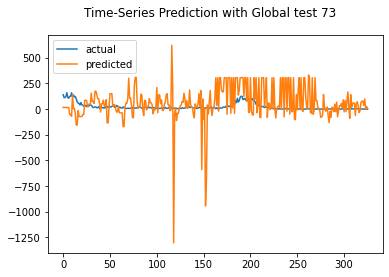

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 74.504
Test sMAPE: 142.179
Test RMSE: 143.152
{'mae': 74.50395513760166, 'smape': 142.17900612995717, 'rmse': 143.15241084598105}


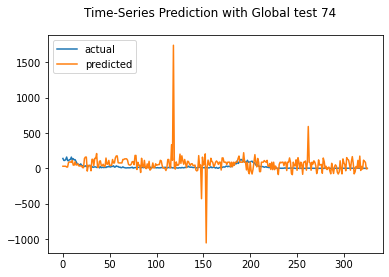

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 114.464
Test sMAPE: 164.414
Test RMSE: 156.428
{'mae': 114.4644595254784, 'smape': 164.41449719655137, 'rmse': 156.42782223060763}


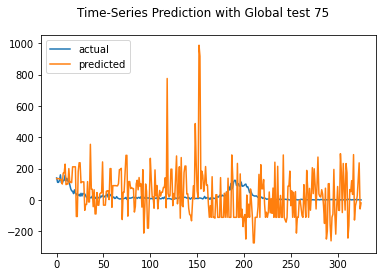

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 55.156
Test sMAPE: 137.658
Test RMSE: 132.392
{'mae': 55.15601311176101, 'smape': 137.65777497429966, 'rmse': 132.3920903454454}


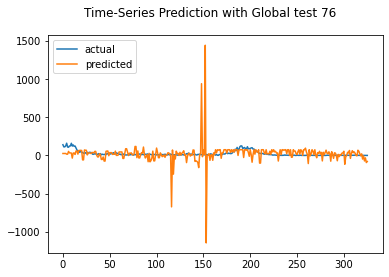

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 119.152
Test sMAPE: 170.586
Test RMSE: 207.172
{'mae': 119.15159455033168, 'smape': 170.58585463337596, 'rmse': 207.17248846278156}


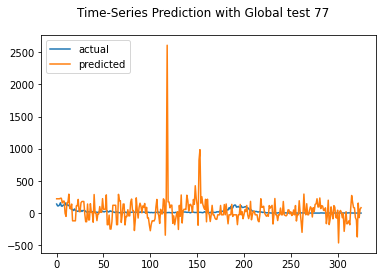

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 76.870
Test sMAPE: 148.034
Test RMSE: 120.700
{'mae': 76.87009896072874, 'smape': 148.03431819220734, 'rmse': 120.70005532069618}


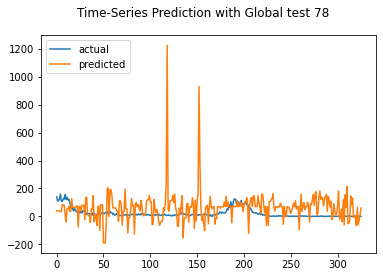

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 158.912
Test sMAPE: 157.063
Test RMSE: 282.508
{'mae': 158.91175353069977, 'smape': 157.06254362803975, 'rmse': 282.50831502261633}


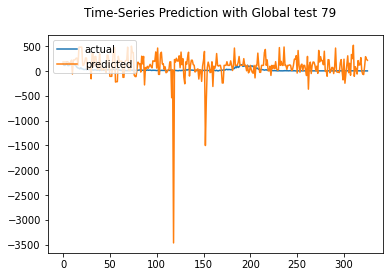

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 71.938
Test sMAPE: 146.079
Test RMSE: 118.968
{'mae': 71.938384077666, 'smape': 146.0785928008136, 'rmse': 118.96805251138771}


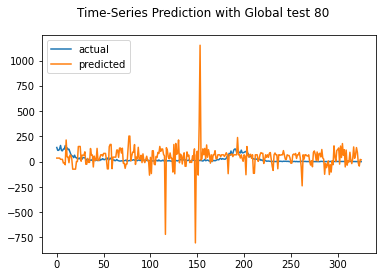

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 86.084
Test sMAPE: 152.660
Test RMSE: 117.777
{'mae': 86.08395367604824, 'smape': 152.66017315509094, 'rmse': 117.77721177604172}


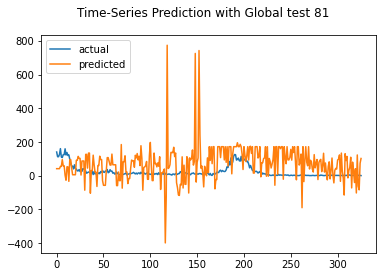

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 252.699
Test sMAPE: 167.708
Test RMSE: 360.762
{'mae': 252.6994028969045, 'smape': 167.70832055581494, 'rmse': 360.76186598250024}


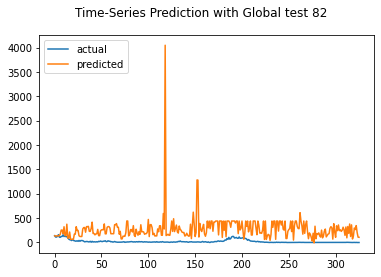

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 164.831
Test sMAPE: 159.790
Test RMSE: 236.208
{'mae': 164.8308565175972, 'smape': 159.7898604777446, 'rmse': 236.20838124529894}


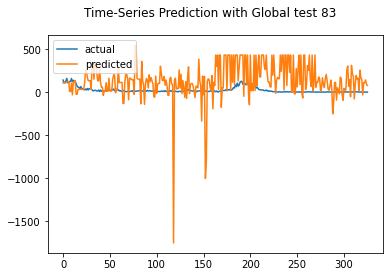

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 72.073
Test sMAPE: 153.246
Test RMSE: 128.719
{'mae': 72.07334521138596, 'smape': 153.24572420426298, 'rmse': 128.71902958668744}


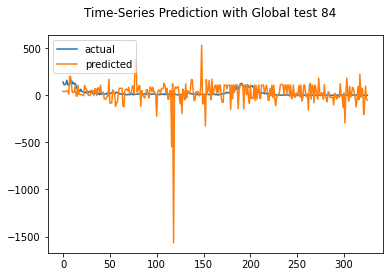

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 131.153
Test sMAPE: 160.545
Test RMSE: 270.899
{'mae': 131.15283139443105, 'smape': 160.54465755963076, 'rmse': 270.8988706084364}


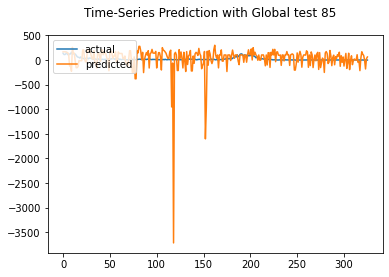

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 64.515
Test sMAPE: 138.329
Test RMSE: 129.814
{'mae': 64.51506044290548, 'smape': 138.32948834323344, 'rmse': 129.81364036611043}


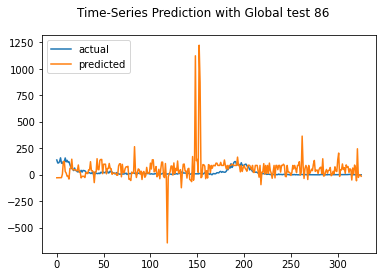

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 77.573
Test sMAPE: 147.301
Test RMSE: 124.358
{'mae': 77.57323327569142, 'smape': 147.30058747353496, 'rmse': 124.35828983313283}


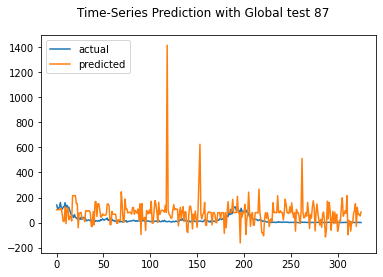

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 54.452
Test sMAPE: 133.458
Test RMSE: 104.374
{'mae': 54.451810956366955, 'smape': 133.45781380849888, 'rmse': 104.3739890968202}


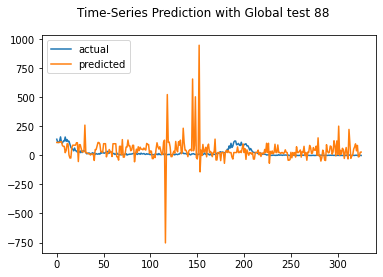

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 90.560
Test sMAPE: 167.619
Test RMSE: 134.934
{'mae': 90.56003796469214, 'smape': 167.61933839827216, 'rmse': 134.93365455373547}


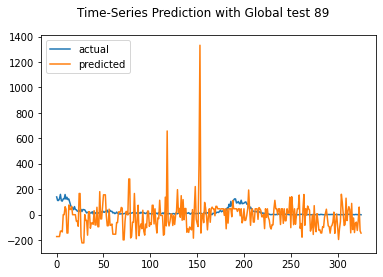

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 72.211
Test sMAPE: 147.610
Test RMSE: 111.384
{'mae': 72.21091784582548, 'smape': 147.6101247512757, 'rmse': 111.38421157461109}


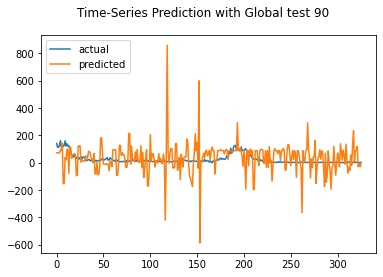

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 82.278
Test sMAPE: 147.427
Test RMSE: 117.415
{'mae': 82.27790221699908, 'smape': 147.42746570372984, 'rmse': 117.41508912431004}


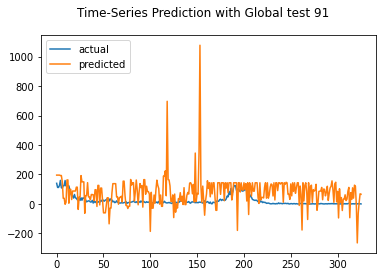

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 65.602
Test sMAPE: 145.630
Test RMSE: 106.588
{'mae': 65.60187655093114, 'smape': 145.63012498677332, 'rmse': 106.58789462130727}


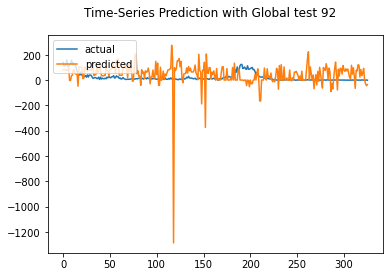

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 111.374
Test sMAPE: 180.054
Test RMSE: 150.289
{'mae': 111.37362699567174, 'smape': 180.0542219794692, 'rmse': 150.28862432093854}


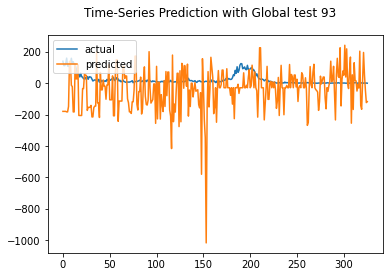

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 140.409
Test sMAPE: 161.428
Test RMSE: 159.476
{'mae': 140.40871624712562, 'smape': 161.42752354097078, 'rmse': 159.47638089406502}


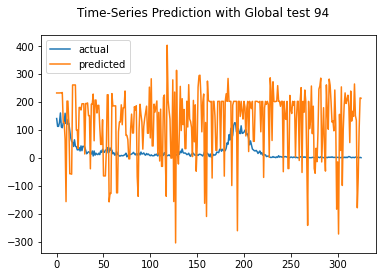

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 78.599
Test sMAPE: 141.783
Test RMSE: 125.137
{'mae': 78.59937651683948, 'smape': 141.78325238666415, 'rmse': 125.13723538522093}


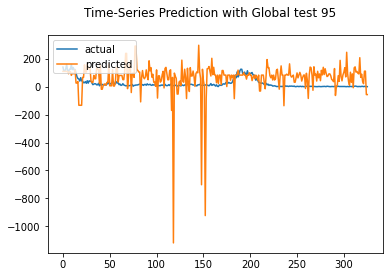

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 291.375
Test sMAPE: 191.468
Test RMSE: 323.326
{'mae': 291.37538372336724, 'smape': 191.46846370295677, 'rmse': 323.32647476945635}


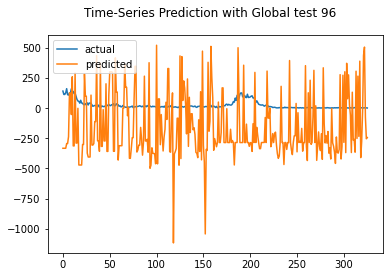

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 86.348
Test sMAPE: 150.629
Test RMSE: 131.433
{'mae': 86.34753190300947, 'smape': 150.62942533693712, 'rmse': 131.43309752665903}


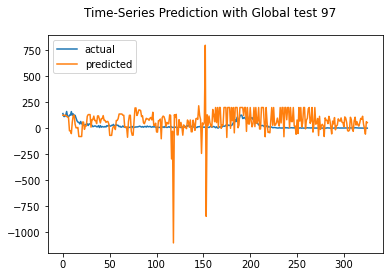

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 190.231
Test sMAPE: 164.635
Test RMSE: 234.734
{'mae': 190.2310340381656, 'smape': 164.63498196265803, 'rmse': 234.73439686384938}


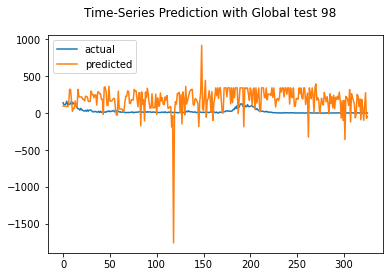

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 137.883
Test sMAPE: 177.647
Test RMSE: 315.509
{'mae': 137.88290973108238, 'smape': 177.64719075892285, 'rmse': 315.50858417060084}


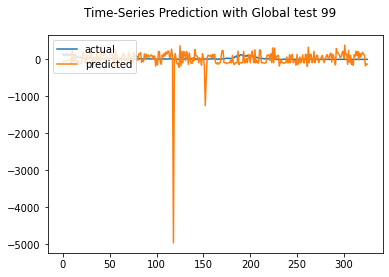

rmse : average=185.712, std=79.154
mae : average=117.536, std=56.277
smape : average=158.925, std=13.572


([185.7123378607221, 79.15391422491922],
 [117.53649073281903, 56.27740530926733],
 [158.92460787147863, 13.57223008163299])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
